# Dependencies

In [ ]:
%pip install coba cloudpickle torch parameterfree vowpalwabbit

# Memory Models
Memory models are non-parametric and can thus approximate any function class given enough examples.

Below we define two CB learners using the VW EMT memory model.

In [169]:
from copy import deepcopy
from typing import Tuple,Sequence, Mapping, Any
from coba import Learner, SafeLearner, VowpalMediator, VowpalLearner, Namespaces, Context, Actions, Action

class EMT:

    def __init__(self, split:int = 100, scorer:str="self_consistent_rank", bound:int=0, features: Sequence[str]=[1,'a','xa']) -> None:

        self._params = {'split':split, 'scorer':scorer, 'bound':bound, 'features':features}

        feat_args = []
        if 1   not in features: feat_args.append('--noconstant')
        if 'a' not in features: feat_args.append('--ignore_linear a')
        if 'x' not in features: feat_args.append('--ignore_linear x')
        feat_args += [ f'--interactions {f}' for f in features if f not in {1, 'a', 'x'} ]

        vw_args = [
            "--emt",
            f"--emt_tree {bound}",
            f"--emt_leaf {split}",
            f"--emt_scorer {scorer}",
            f"--emt_router {'eigen'}",
            f"-b {26}",
            f"--min_prediction 0",
            f"--max_prediction 3",
            f"--coin",
            f"--initial_weight 0",
            *feat_args,
            f'--quiet',
            f'--random_seed 1337'
        ]

        self._vw = VowpalMediator()
        self._vw_args = ' '.join(vw_args)

    @property
    def params(self) -> Mapping[str,Any]:
        return self._params
    
    def predict(self, X: Mapping) -> int:
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        return int(self._vw.predict(self._vw.make_example(X, None)))

    def learn(self, X: Mapping, y: int, weight: float):
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        self._vw.learn(self._vw.make_example(X, f"{int(y)} {weight}"))

class EmtLearner:

    def __init__(self, emt: EMT, epsilon: float = 0.05) -> None:
        assert 0 <= epsilon and epsilon <= 1
        self._epsilon = epsilon
        self._emt     = deepcopy(emt)
        self._rng     = cb.CobaRandom(1)

    @property
    def params(self) -> Mapping[str,Any]:
        return { 'family': 'Eigen', 'e':self._epsilon, **self._emt.params }

    def predict(self, context: Hashable, actions: Sequence[Hashable]) -> Sequence[float]:
        """Choose which action index to take."""

        r_star, A_star = -float('inf'), []
        for action in actions:
            reward = self._emt.predict({'x':context,'a':action})
            if reward > r_star: r_star, A_star = reward, []
            if reward == r_star: A_star.append(action)

        min_p = self._epsilon/len(actions)
        grd_p = (1-self._epsilon)/len(A_star)
        pmf   = [ grd_p+min_p if a in A_star else min_p for a in actions ]

        return self._rng.choicew(actions, pmf)

    def learn(self, context: Hashable, action: Hashable, reward: float, probability: float) -> None:
        """Learn about the result of an action that was taken in a context."""
        self._emt.learn({'x':context,'a':action}, reward, 1)

class EmtStackedLearner:

    def __init__(self, emt: EMT, learner: Learner) -> None:
        self._emt  = deepcopy(emt)
        self._lrn  = SafeLearner(deepcopy(learner))
        self._isvw = isinstance(learner,VowpalLearner)

    @property
    def params(self) -> Mapping[str,Any]:
        params = {**self._emt.params, **self._lrn.params, 'family': 'EigenStacked'}
        params.pop('args',None)
        return params
    
    def _inner_actions(self, context: Context, actions: Actions) -> Actions:
        eigen_pred  = lambda a: float(self._emt.predict({'x':context,'a':a}))
        if self._isvw:
            #I tested adding the memory to the 'a' namespace directly and it didn't work as well
            return [Namespaces(m=eigen_pred(action),a=action) for action in actions]
        else:
            return [[eigen_pred(action), *action] for action in actions]

    def score(self, context: Context, actions: Actions, action: Action) -> float:
        inner_actions = self._inner_actions(context,actions)
        inner_action  = inner_actions[actions.index(action)]
        return self._lrn.score(context,inner_actions,inner_action)

    def predict(self, context: Context, actions: Actions) -> Tuple[Action,float]:
        """Choose which action index to take."""
        
        outer_actions = actions
        inner_actions = self._inner_actions(context,actions)

        inner_action,inner_score,inner_kwargs = self._lrn.predict(context,inner_actions)
        outer_action = outer_actions[inner_actions.index(inner_action)]

        return outer_action, inner_score, {'inner_action': inner_action, 'inner_kwargs': inner_kwargs}

    def learn(self, context: Hashable, action: Hashable, reward: float, score: float, inner_action=None, inner_kwargs={}) -> None:
        """Learn about the result of an action that was taken in a context."""

        inner_action = inner_action or self._inner_actions(context,[action])[0]
        
        self._emt.learn({'x':context,'a':action}, reward, 1)
        self._lrn.learn(context, inner_action, reward, score, **inner_kwargs)

## Memory Model Experiments

### Experiment 1: Memory Can Lift A Parametric Learner 
One way to learn a non-linear reward function is by stacking with a memory model

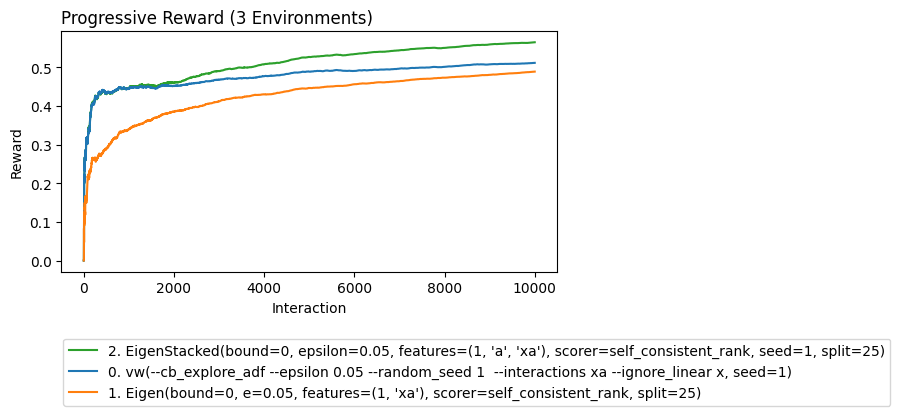

In [171]:
import coba as cb

#EMT remembers rewards and recalls them at prediction time
emt1 = EMT(split=25,features=[1,'xa'])

lrn1 = cb.VowpalEpsilonLearner(features=[1,'a','xa'])#use VW
lrn2 = EmtLearner(emt1)                              #use memory
lrn3 = EmtStackedLearner(emt1,lrn1)                  #use both VW and Memory

lrn = [lrn1,lrn2,lrn3]
env = cb.Environments.from_openml(180).reservoir(10_000,[1,2,3]).scale()

cb.Experiment(env,lrn).run(processes=8,quiet=True).plot_learners()

# Neural Models
Another way to realize non-linear reward functions is to use neural networks.

To do this below we consider two pieces of this puzzle separately:
1. What neural network architecture should we use?
2. How should be explore using the neural network architecture?


## Neural Network Architectures

Here we define several common neural network architectures.

In [25]:
import torch

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, normed=True):
        super().__init__()

        input_norm   = [torch.nn.LayerNorm(in_features)] if normed else []
        output_layer = torch.nn.Linear(in_features=in_features, out_features=out_features)
        
        self.layers  = torch.nn.Sequential(*input_norm,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNet(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden=3, width=None, normed=True):
        super().__init__()

        class PreActivationResidualBlock(torch.nn.Module): #https://arxiv.org/abs/1603.05027
            def __init__(self, in_width, normed=True) -> None:
                super().__init__()

                def not_normed_layer():
                    yield torch.nn.LeakyReLU()
                    yield torch.nn.Linear(in_features=in_width, out_features=in_width)

                def normed_layer():
                    yield torch.nn.LayerNorm(in_width)
                    yield from not_normed_layer()

                layer = normed_layer if normed else not_normed_layer        
                self.layers = torch.nn.Sequential(*layer(),*layer())

            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_norm    = [torch.nn.LayerNorm(in_features)] if normed else []
        input_layer   = [torch.nn.Linear(in_features=in_features, out_features=width)]
        hidden_layers = [PreActivationResidualBlock(width,normed) for _ in range(hidden)]
        output_layer  = torch.nn.Linear(in_features=width, out_features=out_features)

        self.layers = torch.nn.Sequential(*input_norm,*input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class Mlp(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden=3, width=None, normed=True):
        super().__init__()

        def not_normed_layers(_in_width,_out_width):
            yield torch.nn.LeakyReLU()
            yield torch.nn.Linear(in_features=_in_width, out_features=_out_width)

        def normed_layers(_in_width,_out_width):
            yield torch.nn.LayerNorm(_in_width)
            yield from not_normed_layers(_in_width,_out_width)

        width  = width or in_features
        layers = normed_layers if normed else not_normed_layers

        input_norm    = [torch.nn.LayerNorm(in_features)] if normed else []
        input_layer   = [torch.nn.Linear(in_features=in_features, out_features=width)   ]
        hidden_layers = [torch.nn.Sequential(*layers(width,width)) for _ in range(hidden)]
        output_layer  = torch.nn.Linear(in_features=width, out_features=out_features)

        self.layers = torch.nn.Sequential(*input_norm,*input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

## Neural Network Exploration via SquareCB

The exploration algorithm here assumes a regressor (`fhat`) will be instantiated in `define`.

The type of regressor can be anything, we make no assumptions about it, this allows us to use Neural Networks.

In [162]:
from abc import abstractmethod
from coba import CobaContext

class NeuralSquareCbLearner:
    def __init__(self, gamma=1000):
        self.loss   = torch.nn.MSELoss(reduction='none')
        self.fhat   = None
        self.opt    = None
        self.sched  = None
        self.gamma  = gamma
        self._rng   = cb.CobaRandom(1)

    @property
    def params(self):
        return {'gamma':self.gamma}
    
    @abstractmethod
    def define(self,context,action):
        ...

    def predict(self, context, actions):
        context = context or []
        if not self.opt: self.define(list(context),list(actions[0]))

        with torch.no_grad():
            mu = len(actions)
            X  = torch.tensor([list(context)+list(action) for action in actions])
            y  = self.fhat(X)

            rvals       = torch.reshape(y, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self.gamma*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        context = context or []
        if not self.opt: self.define(list(context),list(actions[0]))

        reward      = torch.tensor([reward],dtype=torch.float32)
        pred_reward = self.fhat(torch.tensor(list(context)+list(action)))
        loss_mean   = self.loss(pred_reward, reward).mean()
        
        self.opt.zero_grad()
        loss_mean.backward()
        
        self.opt.step()
        if self.sched: self.sched.step()

        cb.CobaContext.learning_info['MSE'] = loss_mean.item()

## Neural Model Experiments

This experiment compares the COCOB optimizer to the more popular Adam Optimizer.

In my experience the Adam optimizer can usually be tuned to beat the COCOB optimizer but it takes a lot of work.

Due to that, I use the COCOB optimizer in all my proof of concept experiments and only do Adam optimization at the end.

### Experiment 1: Adam optimizer vs Cocob optimizer
#### Learners for Experiment

In [97]:
import parameterfree

class NeuralSquareCbLinearAdam(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Linear(len(context+action),1)
        self.opt   = torch.optim.Adam(self.fhat.parameters(),lr=.1)
        self.sched = torch.optim.lr_scheduler.StepLR(self.opt, 1, .99)

class NeuralSquareCbLinearCocob(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Linear(len(context+action),1)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

class NeuralSquareCbMlpAdam(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Mlp(len(context+action),1)
        self.opt   = torch.optim.Adam(self.fhat.parameters(),lr=.1)
        self.sched = torch.optim.lr_scheduler.StepLR(self.opt, 1, .99)

class NeuralSquareCbMlpCocob(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Mlp(len(context+action),1)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

#### 1. Adam slightly beats Cocob when using Linear architecture

2024-03-04 12:50:02 -- pid-28584  -- Experiment Started
2024-03-04 12:50:03 -- pid-55092  -- Recording Evaluator 0 parameters... (0.02 seconds) (completed)
2024-03-04 12:50:03 -- pid-41648  -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-03-04 12:50:03 -- pid-41648  -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:03 -- pid-42200  -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:04 -- pid-55092  -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:06 -- pid-42200  -- Evaluating Learner 1 on Environment 0... (2.39 seconds) (completed)
2024-03-04 12:50:06 -- pid-41648  -- Evaluating Learner 0 on Environment 0... (2.39 seconds) (completed)
2024-03-04 12:50:06 -- pid-28584  -- Experiment Finished


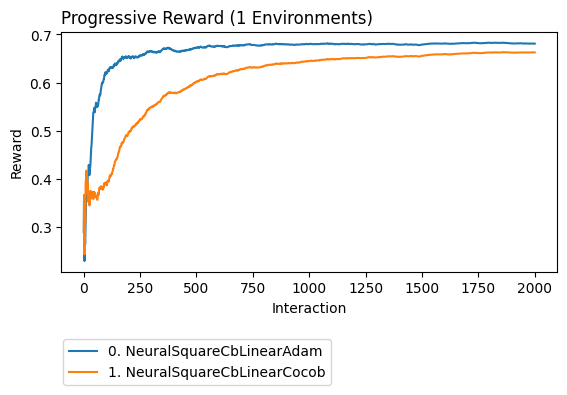

In [39]:
lrn = [NeuralSquareCbLinearAdam(),NeuralSquareCbLinearCocob()]
env = cb.Environments.from_mlp_synthetic(2_000, n_context_features=3, n_action_features=5)
cb.Experiment(env,lrn).run(processes=3).plot_learners()

#### 2. Cocob destroys Adam when using Mlp architecture

2024-03-04 12:50:10 -- pid-28584  -- Experiment Started
2024-03-04 12:50:11 -- pid-38100  -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:11 -- pid-11744  -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-03-04 12:50:11 -- pid-11744  -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:12 -- pid-56540  -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:12 -- pid-38100  -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2024-03-04 12:50:16 -- pid-11744  -- Evaluating Learner 0 on Environment 0... (4.65 seconds) (completed)
2024-03-04 12:50:16 -- pid-56540  -- Evaluating Learner 1 on Environment 0... (4.84 seconds) (completed)
2024-03-04 12:50:17 -- pid-28584  -- Experiment Finished


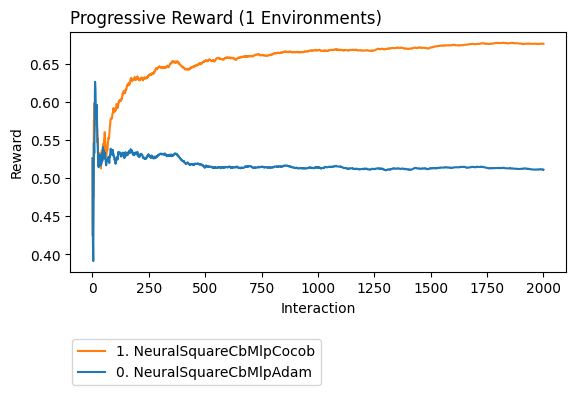

In [40]:
lrn = [NeuralSquareCbMlpAdam(),NeuralSquareCbMlpCocob()]
env = cb.Environments.from_mlp_synthetic(2_000, n_context_features=3, n_action_features=5)
cb.Experiment(env,lrn).run(processes=3).plot_learners()

#### Takeaway

Adam can beat Cocob but only once it has been tuned appropriately. On the other hand, the Cocob optimizer always works without any tuning.

### Experiment 2: Comparing Neural Architectures

#### Learners

In [163]:
import coba
import parameterfree

class NeuralSquareCbLinear(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Linear(len(context+action),1)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

class NeuralSquareCbMlp(NeuralSquareCbLearner):
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = Mlp(len(context+action),1)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

class NeuralSquareCbResNet(NeuralSquareCbLearner):
    def __init__(self,gamma=1000,hidden=3,width=None):
        super().__init__(gamma)
        self.hidden = hidden
        self.width  = width
    @property
    def params(self):
        return {**super().params, 'hidden':self.hidden,'width':self.width}
    def define(self,context,action):
        torch.manual_seed(1)
        self.fhat  = ResNet(len(context+action),1,self.hidden,self.width)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

#### 1. Neural Architecures vs VW on Linear Environment (no quadratic terms)

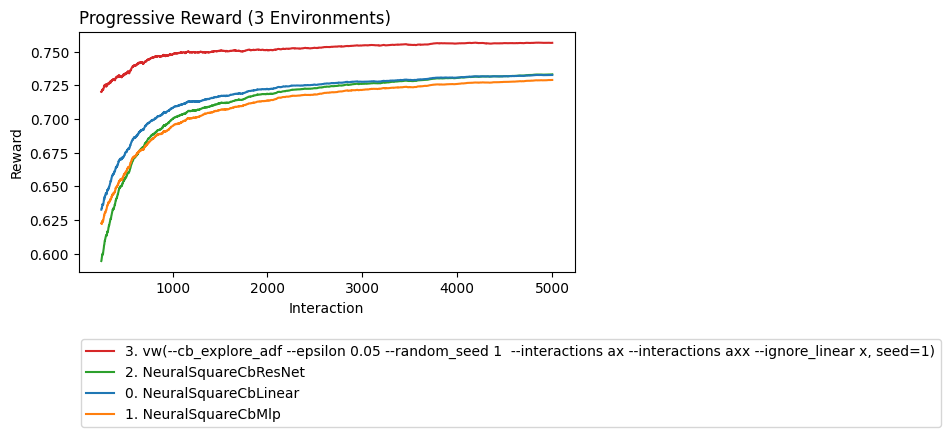

In [60]:
lrn = [NeuralSquareCbLinear(),NeuralSquareCbMlp(),NeuralSquareCbResNet(),coba.VowpalEpsilonLearner()]
env = cb.Environments.from_linear_synthetic(5_000, n_context_features=3, n_action_features=5,reward_features=['a']).shuffle(n=3)
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

#### 2. Neural Architecures vs VW on [MLP Environment](https://coba-docs.readthedocs.io/en/v8.0.3/notebooks/Environments.html#MLP-Synthetic)

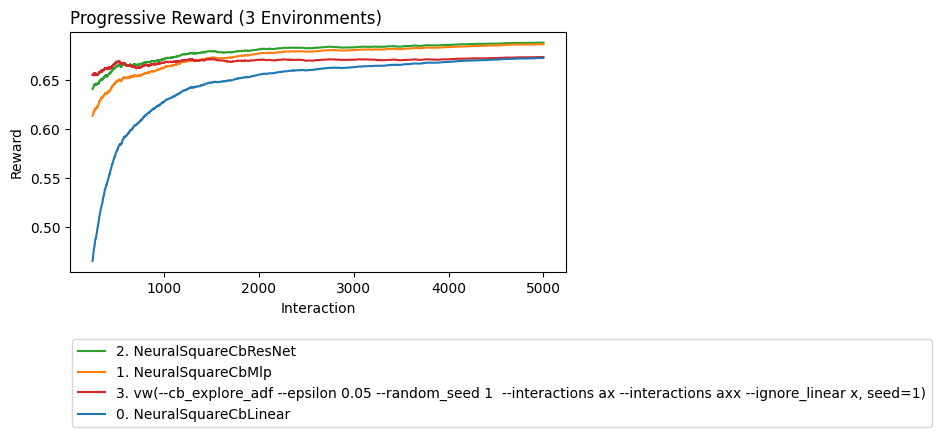

In [71]:
lrn = [NeuralSquareCbLinear(),NeuralSquareCbMlp(),NeuralSquareCbResNet(),coba.VowpalEpsilonLearner()]
env = cb.Environments.from_mlp_synthetic(5_000, n_context_features=3, n_action_features=5).shuffle(n=3)
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

#### 3. Neural Architectures vs VW on [Kernel Environment](https://coba-docs.readthedocs.io/en/v8.0.3/notebooks/Environments.html#Kernel-Synthetic)

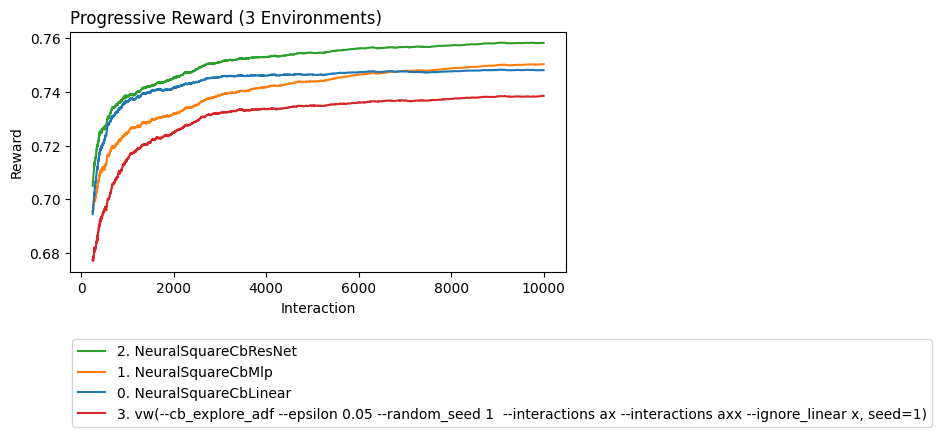

In [69]:
lrn = [NeuralSquareCbLinear(),NeuralSquareCbMlp(),NeuralSquareCbResNet(),coba.VowpalEpsilonLearner()]
env = cb.Environments.from_kernel_synthetic(10_000, n_context_features=0, n_action_features=5, n_exemplars=10, kernel='exponential').shuffle(n=3)
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

#### 3. Neural Architectures vs VW on [Neighborhoods Environment](https://coba-docs.readthedocs.io/en/v8.0.3/notebooks/Environments.html#Neighbors-Synthetic)

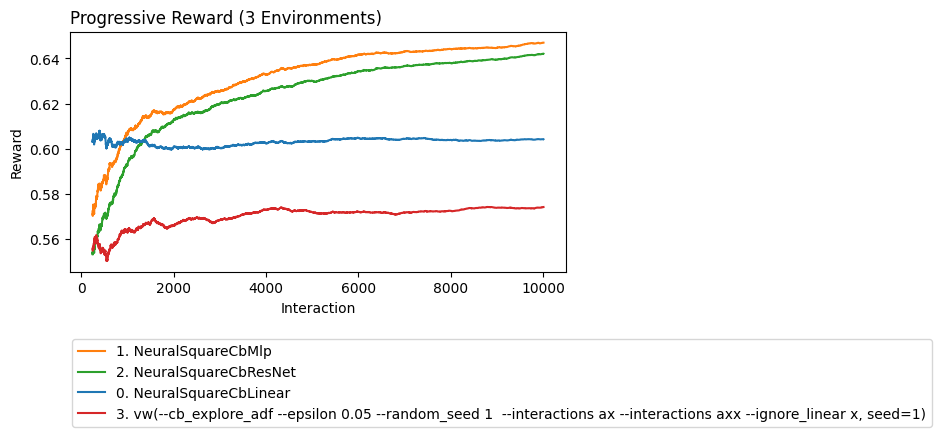

In [72]:
lrn = [NeuralSquareCbLinear(),NeuralSquareCbMlp(),NeuralSquareCbResNet(),coba.VowpalEpsilonLearner()]
env = cb.Environments.from_neighbors_synthetic(10_000, n_context_features=0, n_action_features=5, n_neighborhoods=20).shuffle(n=3)
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

#### Takeaway

When the VW learner's function class is able approximate the reward function of the given environment it does very well. 

As we move into more and more complex environments though we begin to see the VW learner struggle more and more.

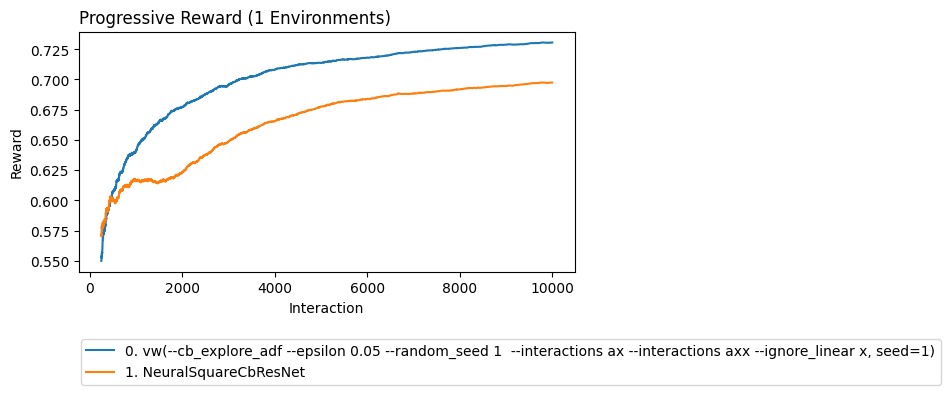

In [135]:
emt1 = EMT(split=200,features=[1,'a','x'])
lrn1 = NeuralSquareCbResNet()
lrn2 = EigenMemoryLearner(emt1)
lrn = [cb.VowpalEpsilonLearner(),lrn2,cb.RandomLearner()]
env = cb.Environments.from_neighbors_synthetic(2_000, n_context_features=4, n_action_features=, n_neighborhoods=2).binary()
#env = cb.Environments.from_linear_synthetic(2_000, n_context_features=1, n_action_features=1).binary()
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

### Experiment 3: Hyperparameter Search of ResNet

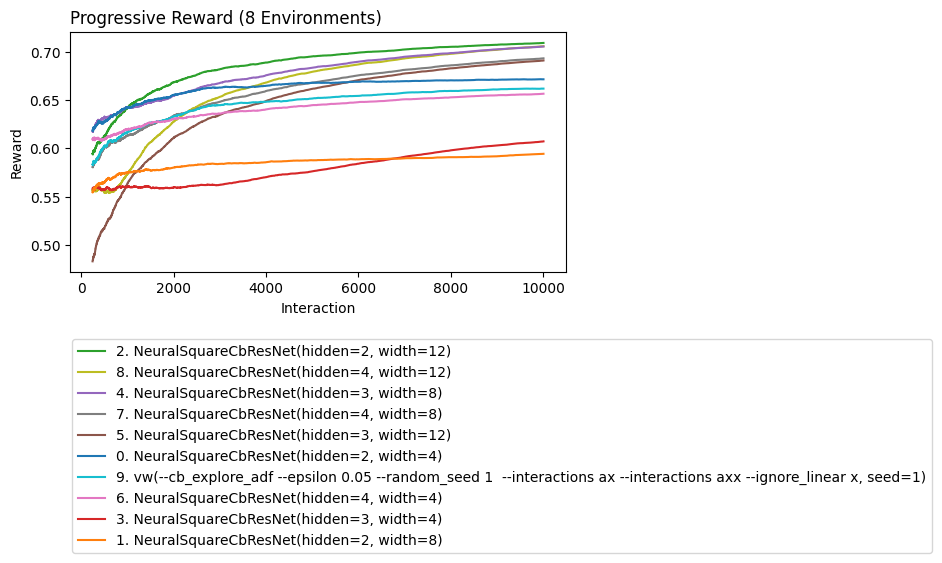

In [144]:
from itertools import product
lrn = [NeuralSquareCbResNet(hidden=h,width=w) for h,w in product([2,3,4],[4,8,12])] + [cb.VowpalEpsilonLearner()]
env = cb.Environments.from_neighbors_synthetic(10_000, n_context_features=4, n_action_features=0, n_neighborhoods=20).shuffle(n=8)
cb.Experiment(env,lrn).run(processes=12,quiet=True).plot_learners(xlim=(250,None))

#### Takeaway
Neural nets are weird... It's not as simple as deeper is better or wider is better...

That said, in general I find resnets to be one of the better performing architectures and mostly focus on them myself.

There are lots of architectures though... Every architecture in this notebook is a feedforward network.

### Experiment 4: Memory Stacking with Neural Architecture
In this final experiment we combine the neural architectures with memory stacking to get our most powerful learner.

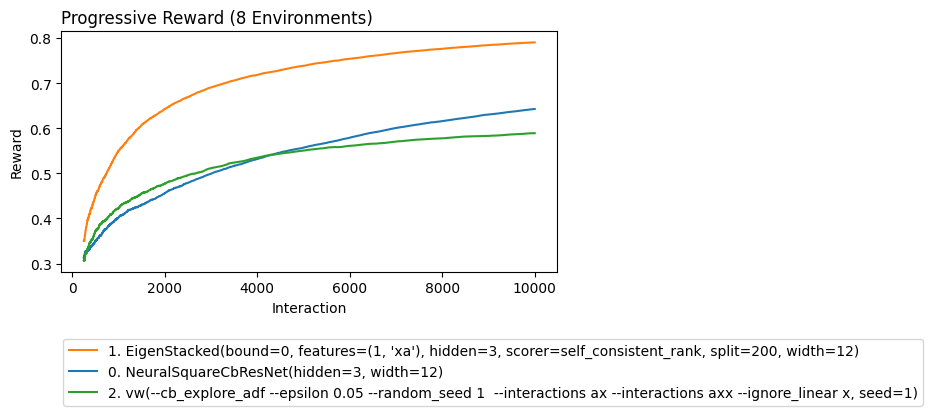

In [147]:
emt1 = EMT(split=200,features=[1,'xa'])
lrn1 = NeuralSquareCbResNet(hidden=3,width=12)
lrn2 = EmtStackedLearner(emt1,lrn1)
lrn = [lrn1,lrn2,cb.VowpalEpsilonLearner()]
env = cb.Environments.from_kernel_synthetic(10_000, n_context_features=4, n_action_features=0, n_exemplars=10, kernel='exponential').binary().shuffle(n=8)
cb.Experiment(env,lrn).run(processes=12,quiet=True).plot_learners(xlim=(250,None))

### Experiment 5: Controlling Exploration
The gamma parameter in squarecb controls exploration. 

A high-value of gamma plays greedily. A low value of gamma plays mostly at random.

In general I like to increase gamma as a function of time.

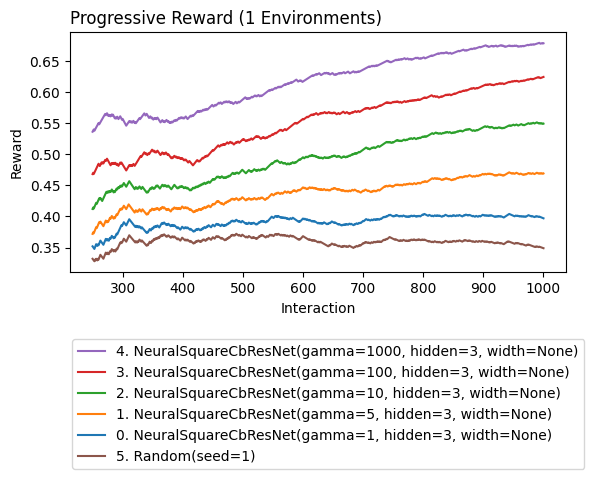

In [161]:
lrn = [NeuralSquareCbResNet(1),NeuralSquareCbResNet(5),NeuralSquareCbResNet(10),NeuralSquareCbResNet(100),NeuralSquareCbResNet(1000),coba.RandomLearner()]
env = cb.Environments.from_mlp_synthetic(1_000, n_context_features=4, n_action_features=0, n_actions=3).binary()
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None))

### Experiment 6: Debugging Bad Performance

SquareCB says that your regret should be upper bounded by the MSE of your regression function.

So, if you aren't learning to predict the reward well for a given context/action pair it won't do well.

This is referred to as "reduction to regression" because SquareCB says if you solve the regression problem you've solved the CB problem.

I've set up the SquareCB learner to also log its MSE so you can also check for problems.

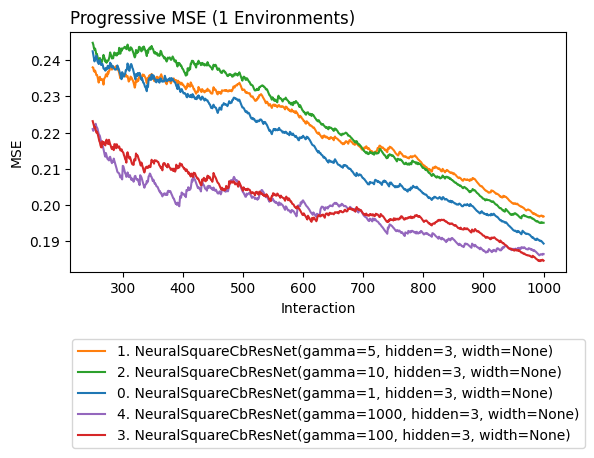

In [164]:
lrn = [NeuralSquareCbResNet(1),NeuralSquareCbResNet(5),NeuralSquareCbResNet(10),NeuralSquareCbResNet(100),NeuralSquareCbResNet(1000)]
env = cb.Environments.from_mlp_synthetic(1_000, n_context_features=4, n_action_features=0, n_actions=3).binary()
cb.Experiment(env,lrn).run(processes=9,quiet=True).plot_learners(xlim=(250,None),y='MSE')

# Conclusion and Final Thoughts

There's a lot here and there isn't one right way to use the models/architectures I've presented.

All the code in here "should" work with off-policy learning from logged data but I haven't tested it.

In the examples above we learned on one example at a time using a single pass over the data. I did this because it was easiest given Coba. In practice, you can see even more lift by making multiple passes over a training set of the data (in neural network terminology these are called training epochs). Using training epochs often gives a really big lift, and it is usually what I do in practice with squarecb neural networks. 

You also hear a lot about mini-batches in neural networks. In my experience mini-batches can speed up training time but don't really improve the final outcome. If you aren't constrained by model training time I wouldn't worry too much about using minibatches.

Finally, to save time in finding a good architecture I often start by simply trying to solve the regression problem and only add the cb complexity after I've found an architecture that works well at minimizing the MSE on reward estimation in a given environment.

Feel free to reach out to me with questions.